In [3]:
import pandas as pd
df = pd.read_csv('credit_card_fraud_dataset.csv')

In [4]:
print("shape:", df.shape)
display(df.head(8))
display(df.info())
display(df.describe(include='all').T)


shape: (100000, 7)


,TransactionID,TransactionDate,Amount,MerchantID,TransactionType,Location,IsFraud
0,1,2024-04-03 14:15:35.462794,4189.27,688,refund,San Antonio,0
1,2,2024-03-19 13:20:35.462824,2659.71,109,refund,Dallas,0
2,3,2024-01-08 10:08:35.462834,784.00,394,purchase,New York,0
3,4,2024-04-13 23:50:35.462850,3514.40,944,purchase,Philadelphia,0
4,5,2024-07-12 18:51:35.462858,369.07,475,purchase,Phoenix,0
5,6,2024-08-30 01:52:35.462867,3086.22,302,purchase,New York,0
6,7,2024-01-02 11:31:35.462875,1466.90,902,refund,Philadelphia,0
7,8,2024-05-12 12:25:35.462885,917.21,266,purchase,New York,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   TransactionID    100000 non-null  int64  
 1   TransactionDate  100000 non-null  object 
 2   Amount           100000 non-null  float64
 3   MerchantID       100000 non-null  int64  
 4   TransactionType  100000 non-null  object 
 5   Location         100000 non-null  object 
 6   IsFraud          100000 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 5.3+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
TransactionID,100000.0,NaN,NaN,NaN,50000.5,28867.657797,1.0,25000.75,50000.5,75000.25,100000.0
TransactionDate,100000,100000,2024-05-20 18:56:36.027551,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Amount,100000.0,NaN,NaN,NaN,2497.092666,1442.415999,1.05,1247.955,2496.5,3743.5925,4999.77
MerchantID,100000.0,NaN,NaN,NaN,501.67607,288.715868,1.0,252.0,503.0,753.0,1000.0
TransactionType,100000,2,refund,50131,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location,100000,10,Chicago,10193,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IsFraud,100000.0,NaN,NaN,NaN,0.01,0.099499,0.0,0.0,0.0,0.0,1.0


In [5]:
print("Missing values (count & %):")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
pd.concat([missing, missing_pct], axis=1, keys=['missing_count','missing_pct']).head(50)

print("\nDuplicate rows:", df.duplicated().sum())

possible_targets = [c for c in df.columns if c.lower() in ('class','isfraud','fraud','label','target')]
print("Possible target cols:", possible_targets)

if 'Time' in df.columns:
    print("Found 'Time' column: consider time-based split for modeling.")


Missing values (count & %):

Duplicate rows: 0
Possible target cols: ['IsFraud']


In [6]:
df.columns = [c.strip().replace(' ','_') for c in df.columns]
for c in df.columns:
    if df[c].dtype == 'object':
        try:
            df[c] = pd.to_numeric(df[c].str.replace(',',''), errors='raise')
        except Exception:
            pass
display(df.dtypes)

TransactionID        int64
TransactionDate     object
Amount             float64
MerchantID           int64
TransactionType     object
Location            object
IsFraud              int64
dtype: object

In [7]:
if len(possible_targets) > 0:
    target_col = possible_targets[0]
else:
    target_col = 'Class'
print("Using target:", target_col)

df[target_col] = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)

counts = df[target_col].value_counts()
print("Class counts:\n", counts)
print("Class distribution (%):\n", df[target_col].value_counts(normalize=True)*100)


Using target: IsFraud
Class counts:
 IsFraud
0    99000
1     1000
Name: count, dtype: int64
Class distribution (%):
 IsFraud
0    99.0
1     1.0
Name: proportion, dtype: float64


In [8]:
missing_summary = pd.concat([df.isnull().sum(), (df.isnull().mean()*100)], axis=1)
missing_summary.columns = ['missing_count','missing_pct']
display(missing_summary.sort_values('missing_pct', ascending=False).head(50))
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

from sklearn.impute import SimpleImputer
num_imputer = SimpleImputer(strategy='median')
df[num_cols] = pd.DataFrame(num_imputer.fit_transform(df[num_cols]), columns=num_cols)

for c in cat_cols:
    df[c] = df[c].fillna('UNKNOWN')

print("After imputation missing check:")
display(df.isnull().sum().head(20))


,missing_count,missing_pct
TransactionID,0,0.0
TransactionDate,0,0.0
Amount,0,0.0
MerchantID,0,0.0
TransactionType,0,0.0
Location,0,0.0
IsFraud,0,0.0


After imputation missing check:


TransactionID      0
TransactionDate    0
Amount             0
MerchantID         0
TransactionType    0
Location           0
IsFraud            0
dtype: int64

In [9]:
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before-after} exact duplicate rows")
if 'Amount' in df.columns:
    print("Amount min/max:", df['Amount'].min(), df['Amount'].max())
if 'Age' in df.columns:
    print("Age min/max:", df['Age'].min(), df['Age'].max())


Dropped 0 exact duplicate rows
Amount min/max: 1.05 4999.77


Numeric columns: ['TransactionID', 'Amount', 'MerchantID', 'IsFraud']


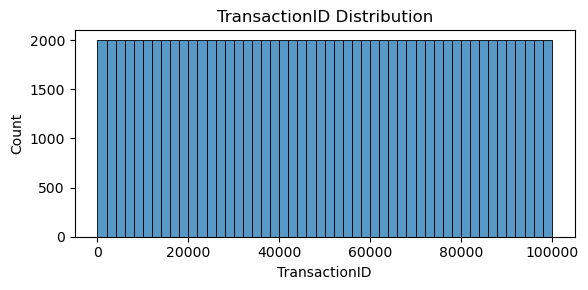

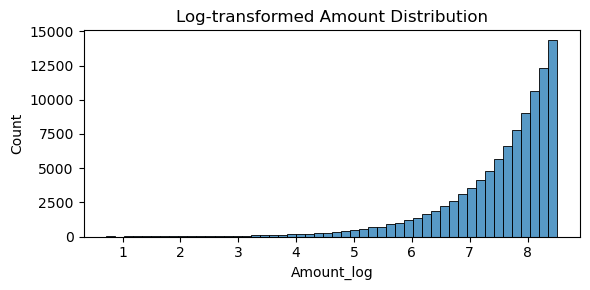

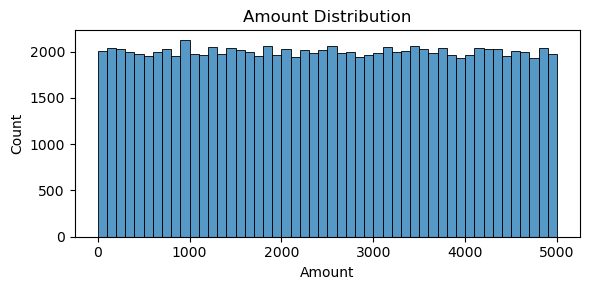

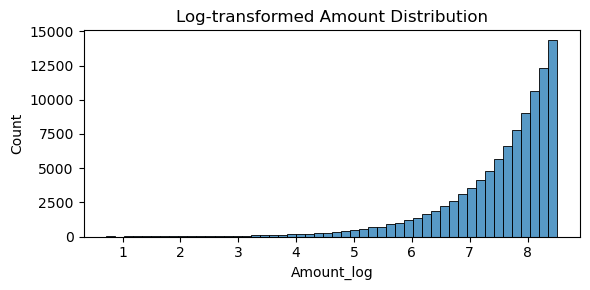

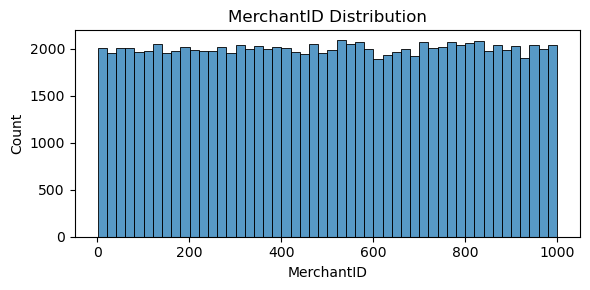

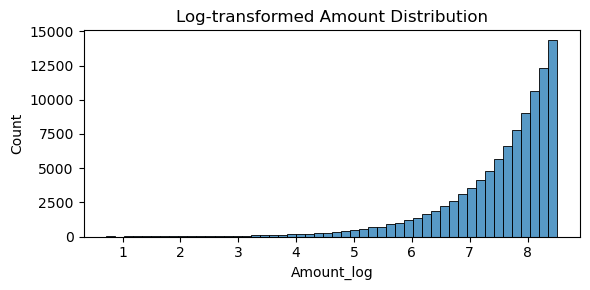

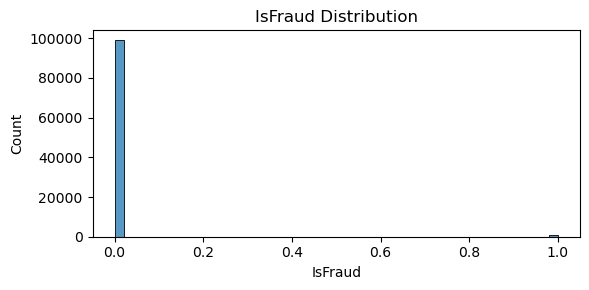

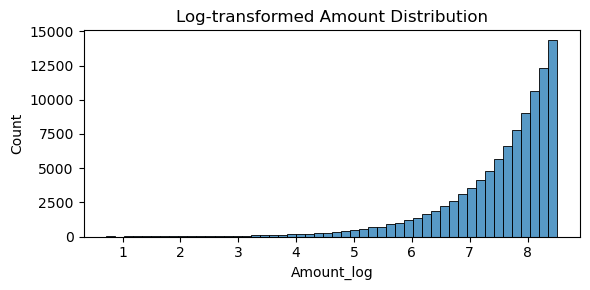

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
num_cols = df.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", num_cols)
for col in num_cols[:6]:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], bins=50)
    plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()
    if 'Amount' in df.columns:
        df['Amount_log'] = np.log1p(df['Amount'].clip(lower=1))

    plt.figure(figsize=(6, 3))
    sns.histplot(df['Amount_log'], bins=50)
    plt.title('Log-transformed Amount Distribution')
    plt.tight_layout()
    plt.show()

Fraud distribution:
IsFraud
0.0    0.99
1.0    0.01
Name: proportion, dtype: float64


<Figure size 1200x500 with 0 Axes>

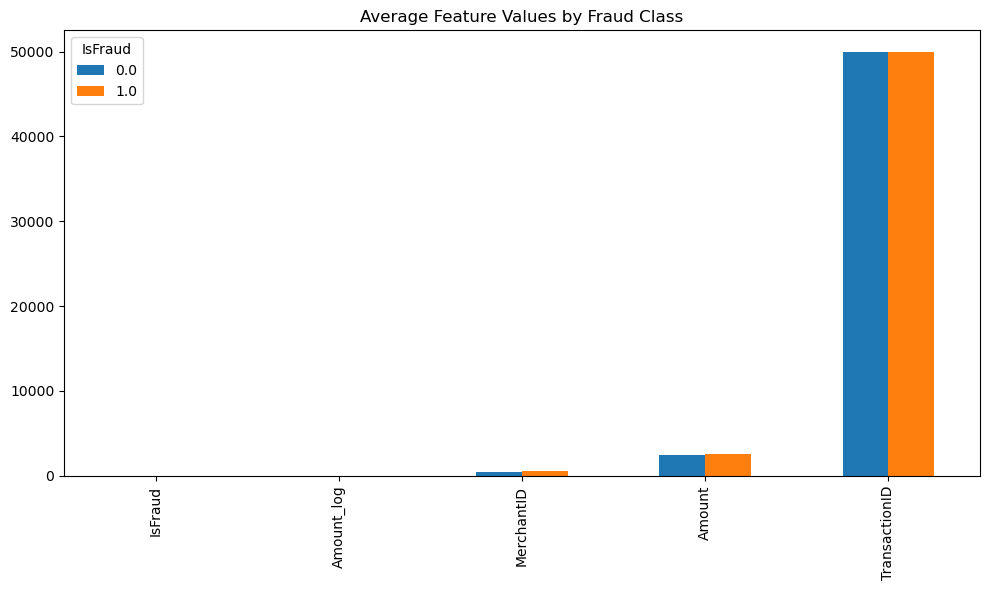

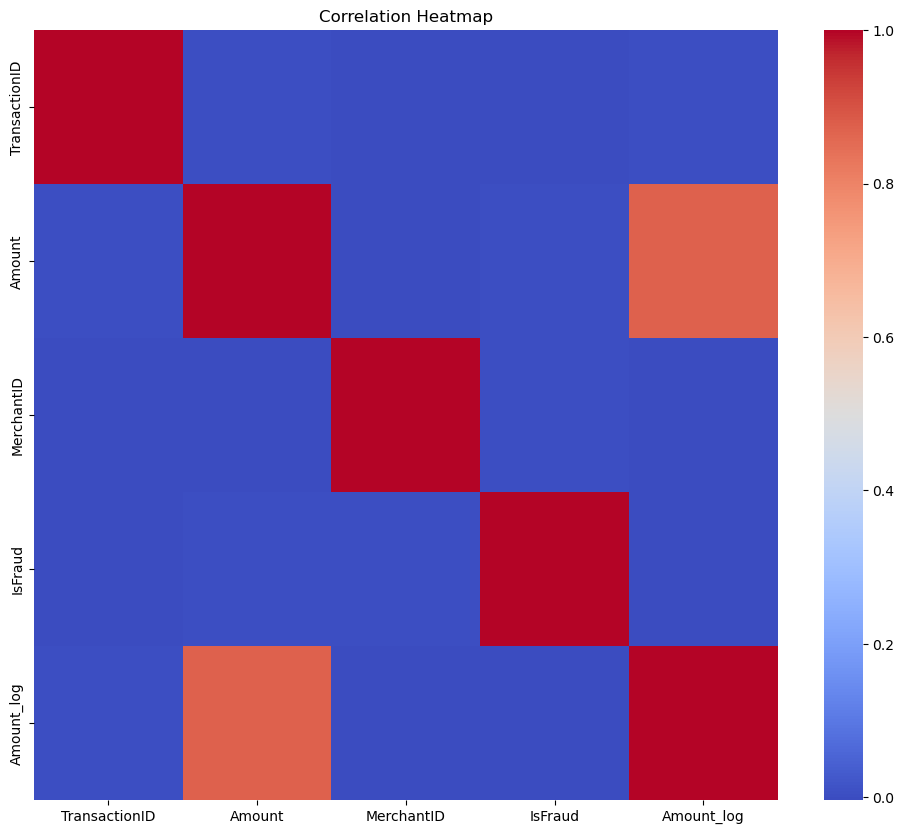

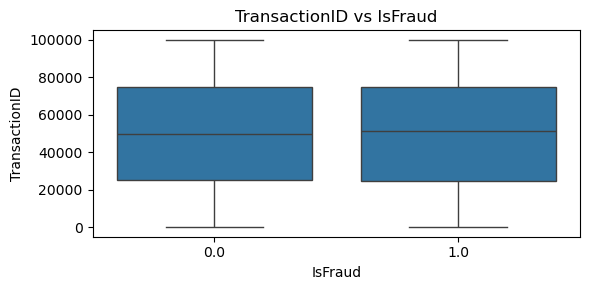

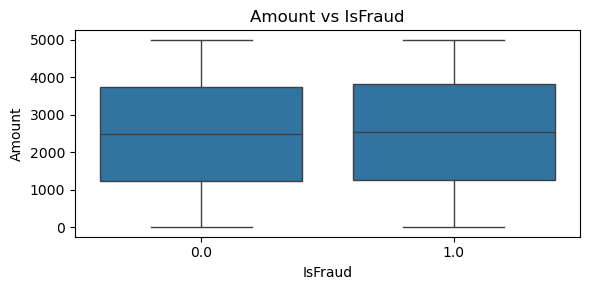

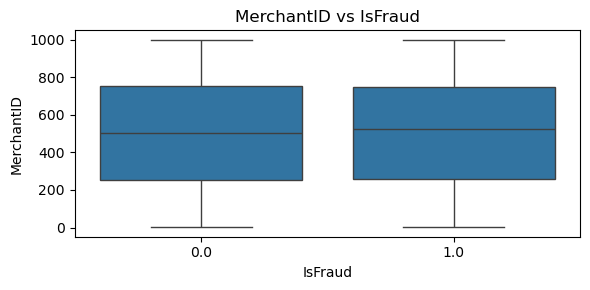

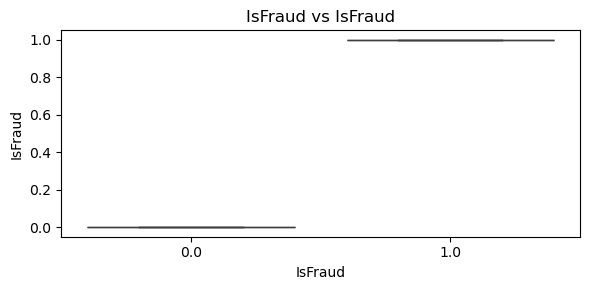

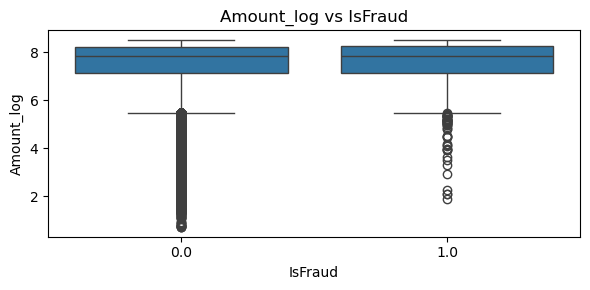

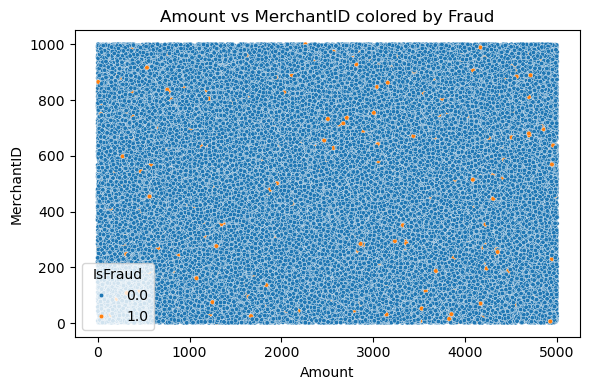

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
target = 'IsFraud'

print("Fraud distribution:")
print(df[target].value_counts(normalize=True))
num_cols = df.select_dtypes(include='number').columns.tolist()

plt.figure(figsize=(12,5))
df.groupby(target)[num_cols].mean().T.sort_values(0).plot(kind='bar', figsize=(10,6))
plt.title("Average Feature Values by Fraud Class")
plt.tight_layout()
plt.show()
plt.figure(figsize=(12,10))
corr = df[num_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()
for col in num_cols[:6]:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=target, y=col, data=df)
    plt.title(f'{col} vs {target}')
    plt.tight_layout()
    plt.show()
if len(num_cols) > 2:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=num_cols[1], y=num_cols[2], hue=target, data=df, s=10)
    plt.title(f'{num_cols[1]} vs {num_cols[2]} colored by Fraud')
    plt.tight_layout()
    plt.show()

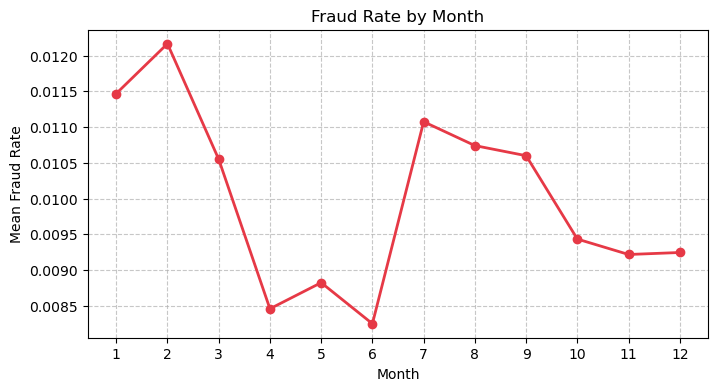

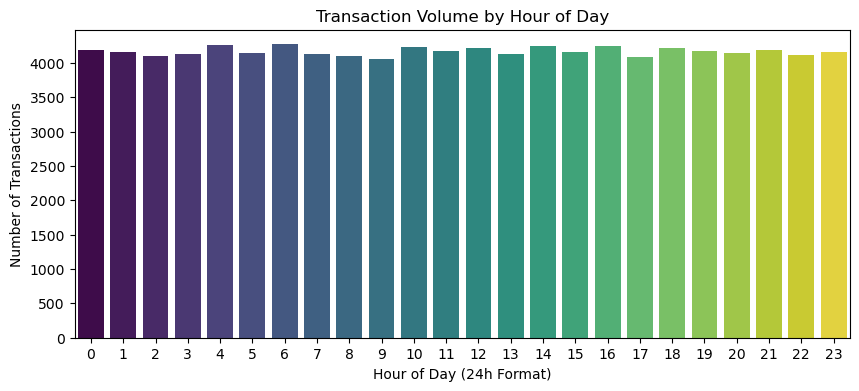

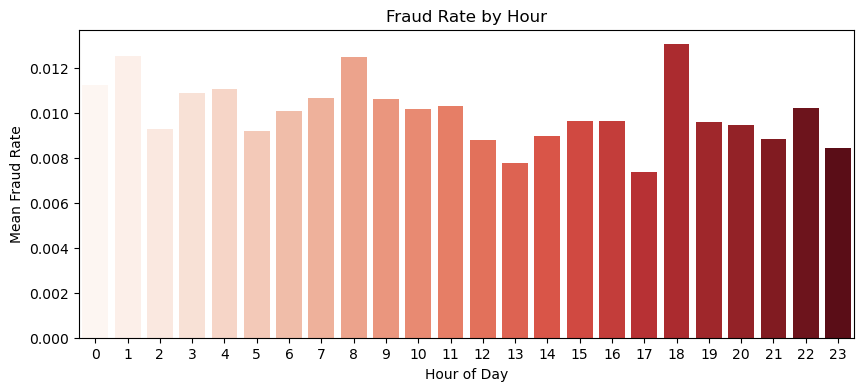

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('credit_card_fraud_dataset.csv')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df = df.dropna(subset=['TransactionDate'])

df['Year'] = df['TransactionDate'].dt.year
df['Month'] = df['TransactionDate'].dt.month
df['Day'] = df['TransactionDate'].dt.day
df['Hour'] = df['TransactionDate'].dt.hour

fraud_month = df.groupby('Month')['IsFraud'].mean()
plt.figure(figsize=(8,4))

fraud_month.plot(kind='line', marker='o', color='#e63946', linewidth=2)
plt.title('Fraud Rate by Month')
plt.xlabel('Month')
plt.ylabel('Mean Fraud Rate')
plt.xticks(range(1,13))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(x='Hour', data=df, palette="viridis", hue='Hour', legend=False)
plt.title('Transaction Volume by Hour of Day')
plt.xlabel('Hour of Day (24h Format)')
plt.ylabel('Number of Transactions')
plt.show()

fraud_hour = df.groupby('Hour')['IsFraud'].mean()
plt.figure(figsize=(10,4))
sns.barplot(x=fraud_hour.index, y=fraud_hour.values, palette="Reds", hue=fraud_hour.index, legend=False)
plt.title('Fraud Rate by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Fraud Rate')
plt.show()

In [15]:
import datetime
holidays = [
    '2022-01-01',  # New Year
    '2022-12-25',  # Christmas
    '2022-07-04',  # Example holiday
]
holidays = pd.to_datetime(holidays)
df['IsHoliday'] = df['TransactionDate'].dt.normalize().isin(holidays)
print(df[['TransactionDate', 'IsHoliday']].head(10))


             TransactionDate  IsHoliday
0 2024-04-03 14:15:35.462794      False
1 2024-03-19 13:20:35.462824      False
2 2024-01-08 10:08:35.462834      False
3 2024-04-13 23:50:35.462850      False
4 2024-07-12 18:51:35.462858      False
5 2024-08-30 01:52:35.462867      False
6 2024-01-02 11:31:35.462875      False
7 2024-05-12 12:25:35.462885      False
8 2023-11-16 02:20:35.462894      False
9 2023-10-24 06:51:35.462901      False


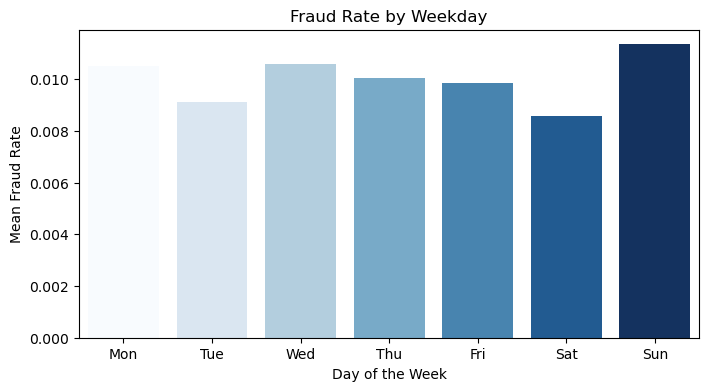

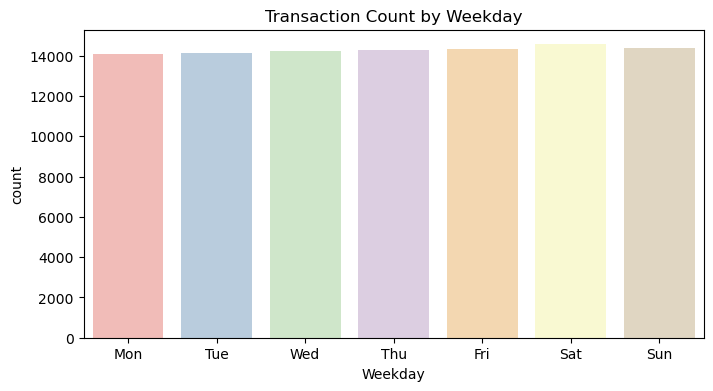

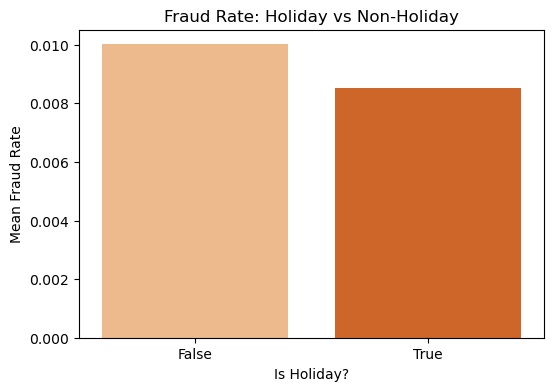

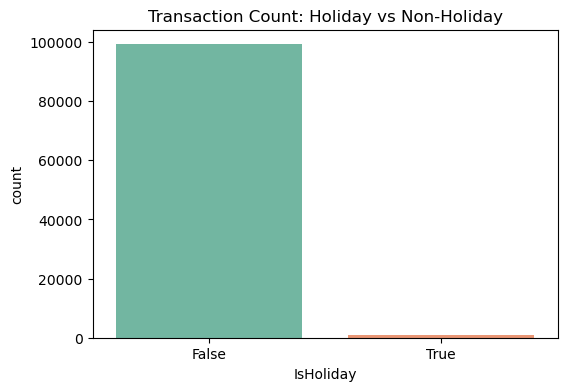

In [5]:
fraud_col = 'IsFraud'
date_col = 'TransactionDate'

df[date_col] = pd.to_datetime(df[date_col])
df['Weekday'] = df[date_col].dt.dayofweek

fraud_weekday = df.groupby('Weekday')[fraud_col].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=fraud_weekday.index, y=fraud_weekday.values, palette="Blues", hue=fraud_weekday.index, legend=False)
plt.title('Fraud Rate by Weekday')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xlabel('Day of the Week')
plt.ylabel('Mean Fraud Rate')
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x='Weekday', data=df, palette="Pastel1", hue='Weekday', legend=False)
plt.title('Transaction Count by Weekday')
plt.xticks(ticks=[0,1,2,3,4,5,6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

holidays = [
    '2023-01-01', '2023-07-04', '2023-12-25', 
    '2024-01-01', '2024-07-04', '2024-12-25'
]
holidays = pd.to_datetime(holidays)

df['IsHoliday'] = df[date_col].dt.normalize().isin(holidays)

fraud_holiday = df.groupby('IsHoliday')[fraud_col].mean()

plt.figure(figsize=(6,4))
sns.barplot(x=fraud_holiday.index, y=fraud_holiday.values, palette="Oranges", hue=fraud_holiday.index, legend=False)
plt.title('Fraud Rate: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday?')
plt.ylabel('Mean Fraud Rate')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='IsHoliday', data=df, palette="Set2", hue='IsHoliday', legend=False)
plt.title('Transaction Count: Holiday vs Non-Holiday')
plt.show()

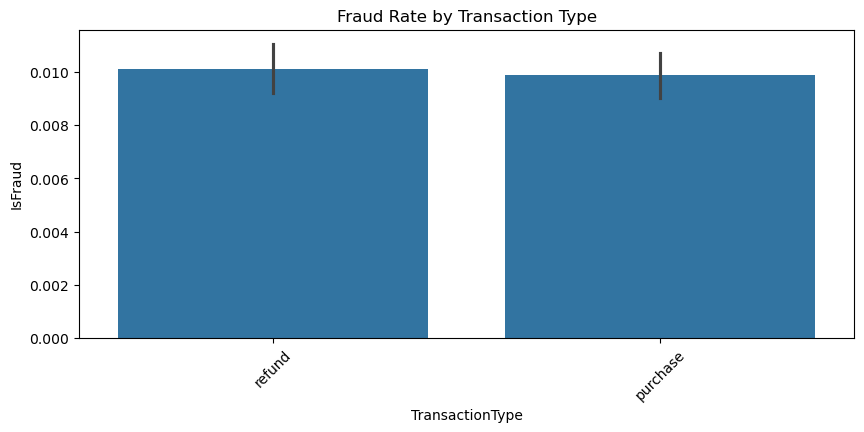

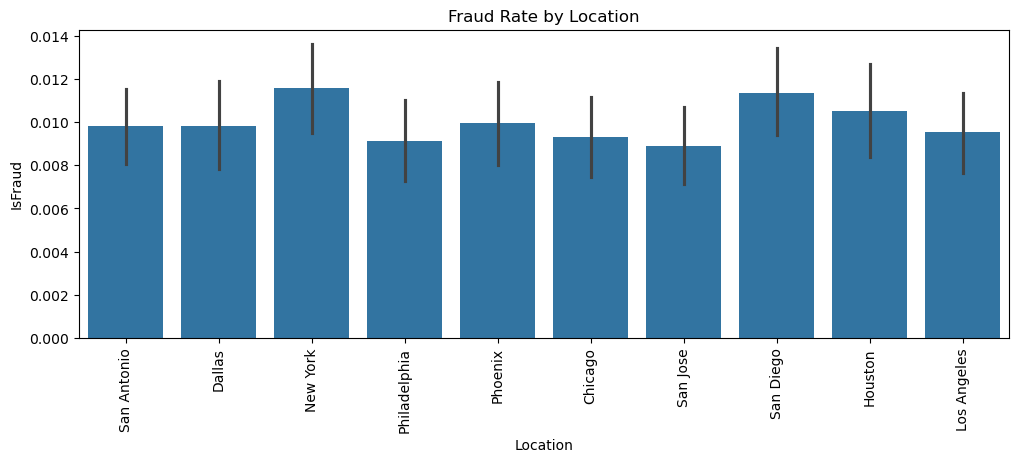

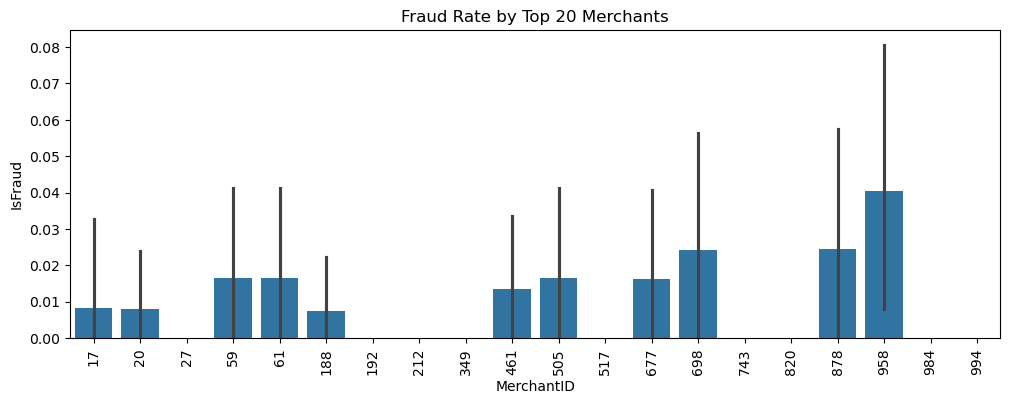

In [6]:
plt.figure(figsize=(10,4))
sns.barplot(x='TransactionType', y='IsFraud', data=df)
plt.title('Fraud Rate by Transaction Type')
plt.xticks(rotation=45)
plt.show()

# Location vs Fraud
plt.figure(figsize=(12,4))
sns.barplot(x='Location', y='IsFraud', data=df)
plt.title('Fraud Rate by Location')
plt.xticks(rotation=90)
plt.show()

# Merchant vs Fraud (Top 20 merchants)
top_merchants = df['MerchantID'].value_counts().head(20).index
temp = df[df['MerchantID'].isin(top_merchants)]

plt.figure(figsize=(12,4))
sns.barplot(x='MerchantID', y='IsFraud', data=temp)
plt.title('Fraud Rate by Top 20 Merchants')
plt.xticks(rotation=90)
plt.show()


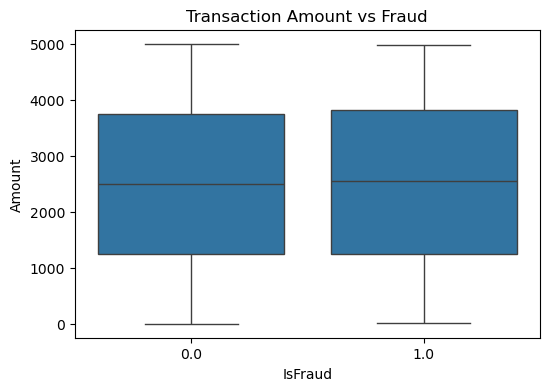

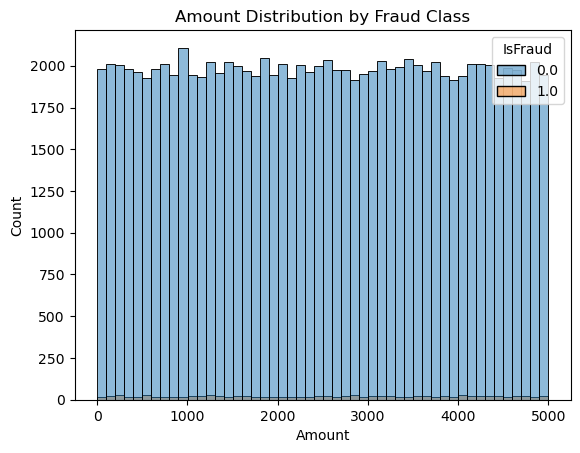

In [23]:
plt.figure(figsize=(6,4))
sns.boxplot(x='IsFraud', y='Amount', data=df)
plt.title('Transaction Amount vs Fraud')
plt.show()

sns.histplot(data=df, x='Amount', hue='IsFraud', bins=50, kde=False)
plt.title('Amount Distribution by Fraud Class')
plt.show()

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

df = pd.read_csv("final_cleaned_fraud_data.csv")

df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["TransactionYear"] = df["TransactionDate"].dt.year
df["TransactionMonth"] = df["TransactionDate"].dt.month
df["TransactionDay"] = df["TransactionDate"].dt.day
df["TransactionHour"] = df["TransactionDate"].dt.hour

df["HourBin"] = pd.cut(df["TransactionHour"], bins=[-1,6,12,18,24],
                       labels=["LateNight","Morning","Afternoon","Evening"])

df = df.drop(columns=["TransactionDate", "TransactionID", "TransactionHour"])

df["Amount_log"] = np.log1p(df["Amount"])

cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

X = df.drop("IsFraud", axis=1)
y = df["IsFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

brf = BalancedRandomForestClassifier(
    n_estimators=300,
    random_state=42,
    max_depth=None,
    replacement=False
)

brf.fit(X_train, y_train)

y_proba = brf.predict_proba(X_test)[:,1]

threshold = 0.3 
y_pred = (y_proba >= threshold).astype(int)

print("Classification Report (Threshold = {}):".format(threshold))
print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

           0      0.985     0.007     0.013     19800
           1      0.010     0.990     0.020       200

    accuracy                          0.016     20000
   macro avg      0.497     0.498     0.016     20000
weighted avg      0.975     0.016     0.013     20000

Confusion Matrix:
 [[  131 19669]
 [    2   198]]



--- FINAL MODEL PREDICTION PERFORMANCE ---
              precision    recall  f1-score   support

           0      0.985     0.007     0.013     19800
           1      0.010     0.990     0.020       200

    accuracy                          0.016     20000
   macro avg      0.497     0.498     0.016     20000
weighted avg      0.975     0.016     0.013     20000



<Figure size 800x600 with 0 Axes>

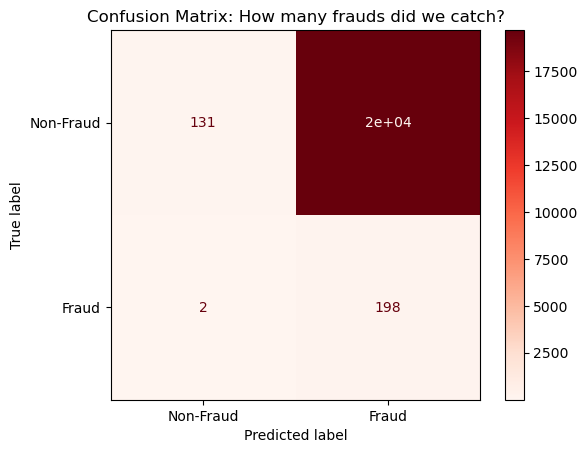

In [45]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n--- FINAL MODEL PREDICTION PERFORMANCE ---")
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

plt.figure(figsize=(8,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Reds', display_labels=["Non-Fraud", "Fraud"])
plt.title("Confusion Matrix: How many frauds did we catch?")
plt.show()


In [33]:

df_ml.to_csv('final_cleaned_fraud_data.csv', index=False)
print("Project Complete! Cleaned CSV saved.")

Project Complete! Cleaned CSV saved.
